# Image Denoising using Convolutional Autoencoder
**Author: Gaurav Shukla**


## Motivation
Noise is a common issue in real-world imaging pipelines — from medical scans to low-light photography. I chose this topic to explore how deep learning, particularly convolutional autoencoders, can be leveraged to recover clean images from noisy inputs.


### Connection with Past and Current Work
- Autoencoders have historically been used for unsupervised feature learning.
- In signal processing, traditional denoising relied on Fourier or wavelet domain filtering.
- Modern approaches integrate denoising into **multimodal learning** pipelines (e.g., for preprocessing in vision-language tasks).
- Convolutional Autoencoders gained traction with their capacity to preserve spatial hierarchies.

### What I Learned
- How encoder-decoder networks compress and reconstruct image data
- Importance of skip connections and architecture tuning
- Evaluation using SSIM and PSNR and visualization of learning curves

## Code & Experiments

### Image Denoising using Convolutional Autoencoders

In [98]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from IPython.display import display, Image as IPImage

### Set random seed for reproducibility


In [100]:
np.random.seed(53)

### Load and preprocess the dataset

In [101]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### Function to add noise

In [102]:
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

### Visualize some noisy images

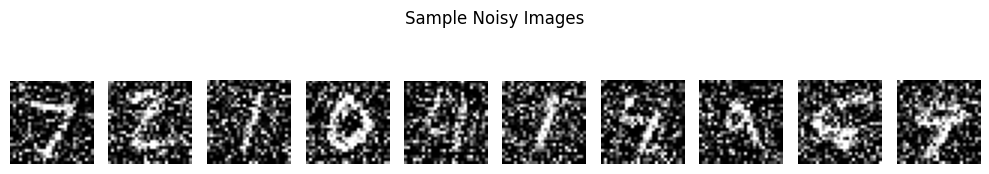

In [103]:
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Sample Noisy Images")
plt.tight_layout()
plt.show()

### Build the Convolutional Autoencoder model

In [105]:
def build_cae(input_shape=(28, 28, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

### Instantiate and compile the model

In [107]:
autoencoder = build_cae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

### Setup callbacks

In [108]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('cae_model.h5', save_best_only=True)
]

### Train the model

In [109]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=callbacks
)


Epoch 1/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2256 - mae: 0.1243

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2253 - mae: 0.1241 - val_loss: 0.1118 - val_mae: 0.0479
Epoch 2/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1108 - mae: 0.0467

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.1108 - mae: 0.0467 - val_loss: 0.1043 - val_mae: 0.0426
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1048 - mae: 0.0424

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.1048 - mae: 0.0424 - val_loss: 0.1012 - val_mae: 0.0402
Epoch 4/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1018 - mae: 0.0403

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.1018 - mae: 0.0403 - val_loss: 0.1000 - val_mae: 0.0389
Epoch 5/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1003 - mae: 0.0392

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.1003 - mae: 0.0392 - val_loss: 0.0982 - val_mae: 0.0381
Epoch 6/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0988 - mae: 0.0383

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0988 - mae: 0.0383 - val_loss: 0.0975 - val_mae: 0.0379
Epoch 7/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0981 - mae: 0.0376

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0981 - mae: 0.0376 - val_loss: 0.0966 - val_mae: 0.0367
Epoch 8/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0973 - mae: 0.0371

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0973 - mae: 0.0371 - val_loss: 0.0960 - val_mae: 0.0366
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 0.0967 - mae: 0.0366 - val_loss: 0.0960 - val_mae: 0.0365
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0959 - mae: 0.0362

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0959 - mae: 0.0362 - val_loss: 0.0951 - val_mae: 0.0357
Epoch 11/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0956 - mae: 0.0359

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0956 - mae: 0.0359 - val_loss: 0.0948 - val_mae: 0.0355
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0951 - mae: 0.0356

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0951 - mae: 0.0356 - val_loss: 0.0946 - val_mae: 0.0352
Epoch 13/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0949 - mae: 0.0354

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0949 - mae: 0.0354 - val_loss: 0.0942 - val_mae: 0.0353
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0945 - mae: 0.0351

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0945 - mae: 0.0351 - val_loss: 0.0942 - val_mae: 0.0350
Epoch 15/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0942 - mae: 0.0349

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0942 - mae: 0.0349 - val_loss: 0.0940 - val_mae: 0.0347
Epoch 16/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0941 - mae: 0.0348

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - loss: 0.0941 - mae: 0.0348 - val_loss: 0.0936 - val_mae: 0.0340
Epoch 17/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0939 - mae: 0.0347

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.0939 - mae: 0.0347 - val_loss: 0.0934 - val_mae: 0.0344
Epoch 18/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 0.0936 - mae: 0.0345 - val_loss: 0.0935 - val_mae: 0.0343
Epoch 19/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0936 - mae: 0.0344

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0936 - mae: 0.0344 - val_loss: 0.0932 - val_mae: 0.0345
Epoch 20/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0933 - mae: 0.0343

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0933 - mae: 0.0343 - val_loss: 0.0931 - val_mae: 0.0342
Epoch 21/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0932 - mae: 0.0342

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0932 - mae: 0.0342 - val_loss: 0.0930 - val_mae: 0.0341
Epoch 22/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0931 - mae: 0.0341 - val_loss: 0.0933 - val_mae: 0.0346
Epoch 23/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0930 - mae: 0.0340

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0930 - mae: 0.0340 - val_loss: 0.0929 - val_mae: 0.0341
Epoch 24/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0930 - mae: 0.0339

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0930 - mae: 0.0339 - val_loss: 0.0927 - val_mae: 0.0338
Epoch 25/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0926 - mae: 0.0338 - val_loss: 0.0927 - val_mae: 0.0334
Epoch 26/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0926 - mae: 0.0337

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0926 - mae: 0.0337 - val_loss: 0.0926 - val_mae: 0.0338
Epoch 27/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0926 - mae: 0.0338 - val_loss: 0.0932 - val_mae: 0.0339
Epoch 28/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0927 - mae: 0.0337 - val_loss: 0.0926 - val_mae: 0.0338
Epoch 29/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0925 - mae: 0.0337

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0925 - mae: 0.0337 - val_loss: 0.0925 - val_mae: 0.0335
Epoch 30/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0923 - mae: 0.0335

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0923 - mae: 0.0335 - val_loss: 0.0924 - val_mae: 0.0336
Epoch 31/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0921 - mae: 0.0334 - val_loss: 0.0924 - val_mae: 0.0336
Epoch 32/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0922 - mae: 0.0334

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0922 - mae: 0.0334 - val_loss: 0.0923 - val_mae: 0.0334
Epoch 33/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0921 - mae: 0.0334 - val_loss: 0.0924 - val_mae: 0.0339
Epoch 34/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0919 - mae: 0.0333 - val_loss: 0.0930 - val_mae: 0.0339
Epoch 35/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0919 - mae: 0.0332

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.0919 - mae: 0.0332 - val_loss: 0.0922 - val_mae: 0.0333
Epoch 36/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0921 - mae: 0.0333

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0921 - mae: 0.0333 - val_loss: 0.0921 - val_mae: 0.0337
Epoch 37/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.0919 - mae: 0.0332 - val_loss: 0.0927 - val_mae: 0.0338
Epoch 38/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0918 - mae: 0.0332 - val_loss: 0.0922 - val_mae: 0.0338
Epoch 39/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0917 - mae: 0.0331

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0917 - mae: 0.0331 - val_loss: 0.0921 - val_mae: 0.0333
Epoch 40/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - loss: 0.0918 - mae: 0.0331 - val_loss: 0.0922 - val_mae: 0.0331
Epoch 41/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0918 - mae: 0.0331 - val_loss: 0.0923 - val_mae: 0.0336
Epoch 42/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0917 - mae: 0.0331

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0917 - mae: 0.0331 - val_loss: 0.0920 - val_mae: 0.0333
Epoch 43/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.0915 - mae: 0.0330 - val_loss: 0.0921 - val_mae: 0.0332
Epoch 44/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.0915 - mae: 0.0330 - val_loss: 0.0921 - val_mae: 0.0333
Epoch 45/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0914 - mae: 0.0329 - val_loss: 0.0925 - val_mae: 0.0336
Epoch 46/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 0.0915 - mae: 0.0330 - val_loss: 0.0923 - val_mae: 0.0335
Epoch 47/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0915 - mae: 0.0330

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0915 - mae: 0.0330 - val_loss: 0.0919 - val_mae: 0.0331
Epoch 48/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0914 - mae: 0.0329 - val_loss: 0.0923 - val_mae: 0.0330
Epoch 49/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0912 - mae: 0.0328 - val_loss: 0.0922 - val_mae: 0.0334
Epoch 50/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - loss: 0.0913 - mae: 0.0328 - val_loss: 0.0920 - val_mae: 0.0333


### Plot training history


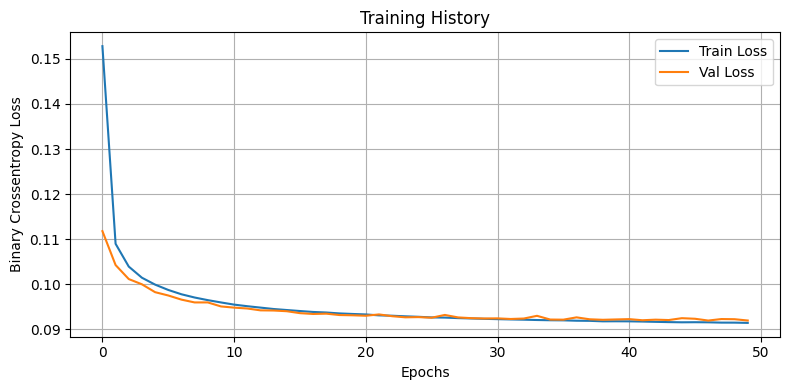

In [111]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Evaluate on test data


In [112]:
reconstructed = autoencoder.predict(x_test_noisy)



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


### Calculate metrics


In [113]:
psnr = np.mean([peak_signal_noise_ratio(x_test[i], reconstructed[i]) for i in range(100)])
ssim = np.mean([structural_similarity(x_test[i].squeeze(), reconstructed[i].squeeze(), data_range=1.0) for i in range(100)])
print(f"Average PSNR: {psnr:.2f}")
print(f"Average SSIM: {ssim:.4f}")



Average PSNR: 20.45
Average SSIM: 0.8733


### Visualize results

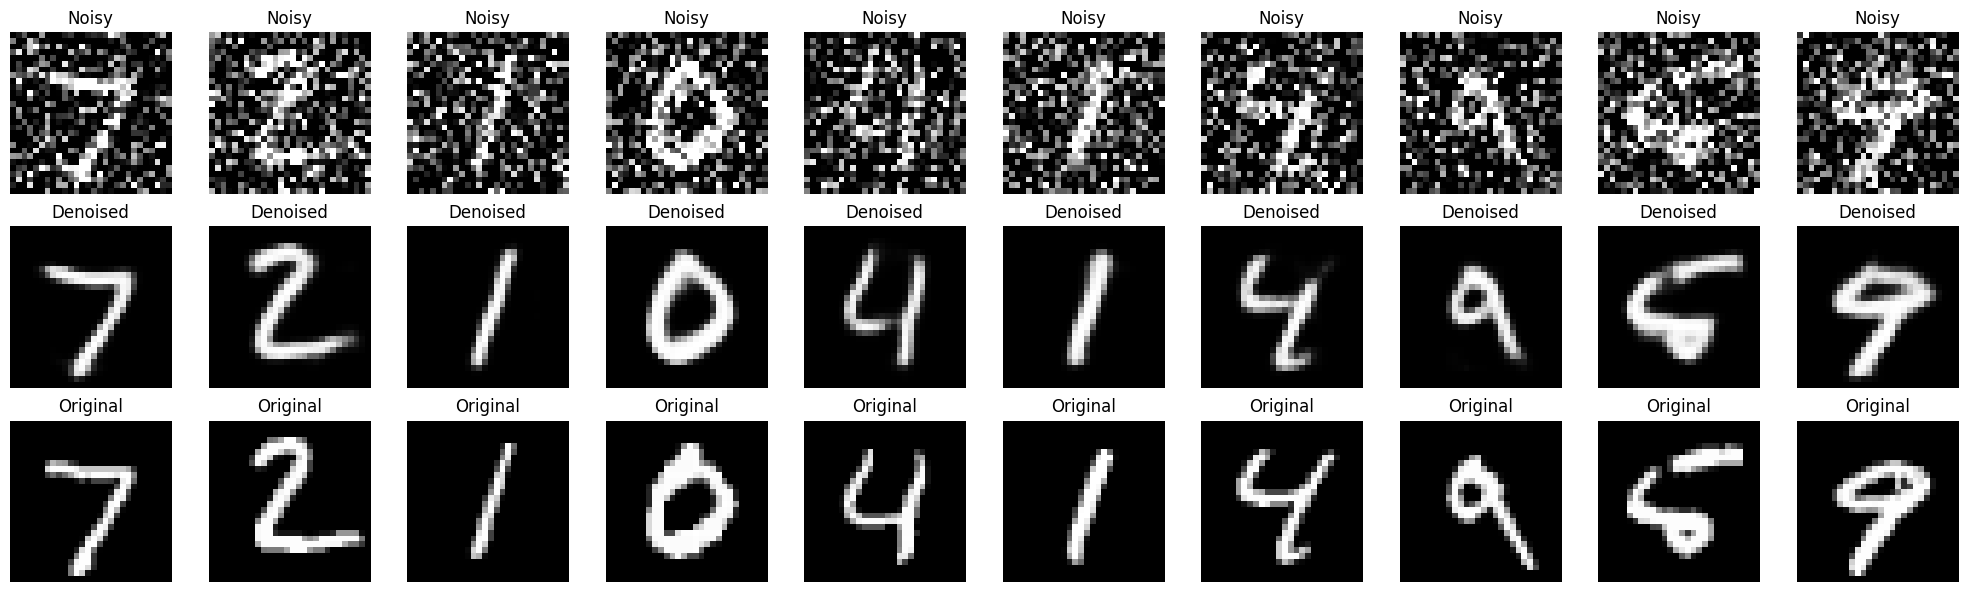

In [114]:
def display_results(noisy_imgs, denoised_imgs, clean_imgs, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(clean_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_results(x_test_noisy, reconstructed, x_test)

## Reflections

### What surprised me:
- Even a simple CAE learned to suppress most Gaussian noise effectively.
- Training on MNIST generalized better than expected.

### Improvements:
- Explore skip connections (UNet style)
- Train on high-res datasets like DIV2K, BSD500
- Try other noise types (speckle, salt & pepper)

## References
- [Deep Learning Book - Ian Goodfellow](https://www.deeplearningbook.org/)
- [Autoencoder Tutorial by François Chollet](https://blog.keras.io/building-autoencoders-in-keras.html)
- [scikit-image Metrics](https://scikit-image.org/docs/stable/api/skimage.metrics.html)
- ChatGPT-4 (OpenAI) for architecture suggestions and documentation clarity